## Imports

In [1]:
import pandas as pd
import sys, os, importlib
from datetime import datetime
import numpy as np

In [2]:
pd.set_option('display.max_rows', 100)

if os.path.join('..','0_funcoes_base') not in sys.path:
    sys.path.append(os.path.join('..','0_funcoes_base')) 

df_manipulator = importlib.import_module('df_manipulator')
date_manipulator = importlib.import_module('date_manipulator')
plot_manipulator = importlib.import_module('plot_manipulator')


## Dados de configuração

In [3]:
input_config = {
    'file': {
        'ref_dir':'./out/',
        'filename':'1_export_lunar_20200517.csv',
        'delimiter': ';'
    },
    'max_consecutive_nan': 10,
}

output_config = {
    'file': {
    'ref_dir': './out',
    'delimiter':';',
    'with_header': True
    }
}

## Funções

In [4]:
def get_speed_bumps_idx(df, speed_bump_id = None):
    if not speed_bump_id or speed_bump_id < 0:
        return df[df.speedBumpId != speed_bump_id].index.to_list()
    return df[df.speedBumpId == speed_bump_id].index.to_list()
    

def get_out_filename(prefix):
    return os.path.join(output_config['file']['ref_dir'], prefix + output_config['file']['filename'].replace('1_', ''))

## Carrega dataframe

In [5]:
df = df_manipulator.load_dataframe(input_config['file']['filename'], input_config['file']['ref_dir'], input_config['file']['delimiter'])
df.timestamp = pd.to_datetime(df.timestamp)
df_manipulator.set_index(df, 'timestamp', True)

In [6]:
df

,id,speedBumpId,x,y,z,lat,lng
timestamp,,,,,,,
2020-05-17 20:10:48.346,d198e52b-bd5b-424a-8ea5-d391fbdb7b20,0,-3.399200,9.516205,1.573975,-22.921991,-42.473372
2020-05-17 20:10:48.543,a9df8305-e4ed-4530-ab78-e1aa3ca9ffbd,0,-2.987396,10.203339,1.291458,-22.921991,-42.473372
2020-05-17 20:10:48.743,74dedc33-8d9b-4aa6-a352-df1ee9364ed7,0,-4.376038,9.746048,1.806213,-22.921991,-42.473372
2020-05-17 20:10:48.843,4a64f1bf-ea98-49db-baff-d7d08baf2dce,0,-3.698471,9.317490,1.849304,-22.921991,-42.473372
2020-05-17 20:10:48.944,25a3976b-a812-4bf2-a2fe-113d7b01cd11,0,-5.039230,9.372559,0.522919,-22.921991,-42.473372
...,...,...,...,...,...,...,...
2020-05-17 20:35:51.161,0f15d4aa-c4c3-40ba-9d1f-1746e938a5eb,0,0.386032,10.105179,1.660172,-22.925816,-42.484631
2020-05-17 20:35:51.261,c044a484-bb8b-421b-8cc8-a6ad4713e28f,0,-1.378494,9.920822,2.608276,-22.925816,-42.484631
2020-05-17 20:35:51.361,c9d94f9a-6211-4198-b39b-70db0ef2e890,0,-1.215683,9.523392,2.505325,-22.925816,-42.484631


## Regulariza intervalos do index (timestamp)

In [9]:
df_out = df.resample('100ms').ffill()
df_out.dropna(inplace=True, how='all')

In [12]:
df_manipulator.apply_describe(df_out)

Shape:
 (15032, 7)
Types:

float64 :  ['speedBumpId' 'x' 'y' 'z' 'lat' 'lng']
object :  ['id']





,null_sum,null_pct,dtypes,count,mean,median,min,max
id,0,0.0,object,15032,NaN,NaN,0000103f-58f2-4b67-956e-9fc49ea2a845,ffe9ed07-2030-4a2d-ad61-18af6217f012
lat,0,0.0,float64,15032,-22.916766,-22.921991,-22.9355,-22.8901
lng,0,0.0,float64,15032,-42.478807,-42.476058,-42.4957,-42.4683
speedBumpId,0,0.0,float64,15032,0.007118,0.000000,0,2
x,0,0.0,float64,15032,-1.631164,-0.770370,-12.7126,5.52878
y,0,0.0,float64,15032,9.100066,9.252838,3.04707,15.6933
z,0,0.0,float64,15032,2.323634,2.409546,-8.12733,15.8889


In [10]:
df_out

,id,speedBumpId,x,y,z,lat,lng
timestamp,,,,,,,
2020-05-17 20:10:48.400,d198e52b-bd5b-424a-8ea5-d391fbdb7b20,0.0,-3.399200,9.516205,1.573975,-22.921991,-42.473372
2020-05-17 20:10:48.500,d198e52b-bd5b-424a-8ea5-d391fbdb7b20,0.0,-3.399200,9.516205,1.573975,-22.921991,-42.473372
2020-05-17 20:10:48.600,a9df8305-e4ed-4530-ab78-e1aa3ca9ffbd,0.0,-2.987396,10.203339,1.291458,-22.921991,-42.473372
2020-05-17 20:10:48.700,a9df8305-e4ed-4530-ab78-e1aa3ca9ffbd,0.0,-2.987396,10.203339,1.291458,-22.921991,-42.473372
2020-05-17 20:10:48.800,74dedc33-8d9b-4aa6-a352-df1ee9364ed7,0.0,-4.376038,9.746048,1.806213,-22.921991,-42.473372
...,...,...,...,...,...,...,...
2020-05-17 20:35:51.100,72df7adf-cb5f-4f91-b76d-f08fa6da21ed,0.0,-0.700928,9.250443,1.770294,-22.925816,-42.484631
2020-05-17 20:35:51.200,0f15d4aa-c4c3-40ba-9d1f-1746e938a5eb,0.0,0.386032,10.105179,1.660172,-22.925816,-42.484631
2020-05-17 20:35:51.300,c044a484-bb8b-421b-8cc8-a6ad4713e28f,0.0,-1.378494,9.920822,2.608276,-22.925816,-42.484631


## Ajusta momento da marcação de quebra-mola

In [ ]:
def fix_manual_event_timestamp(df, speed_bump_id=None):
    _df = df.copy()

    sb_idx = get_speed_bumps_idx(_df, speed_bump_id)
    if len(sb_idx) < 1:
        return _df
    


In [ ]:
df_out = fix_manual_event_timestamp(df_out)

In [1089]:
mapping_window = 2000
max_idx = max(df.index)
min_idx = min(df.index)

#print(f'min_idx\n {min_idx}')
#print(f'max_idx\n {max_idx}')


mapping_timestamp_event = {}

for sb_idx in speedbumps_idx:
    mapping_timestamp_event[sb_idx] = {}

    min_range = sb_idx - pd.Timedelta(mapping_window, 'milliseconds')
    max_range = sb_idx + pd.Timedelta(mapping_window, 'milliseconds')
    
    min_range = min_range if min_range >= min_idx else min_idx
    max_range = max_range if max_range <= max_idx else max_idx
    
    search_values = pd.date_range(start=min_range, end=max_range, freq=str(100) + ' ' + 'ms')

    #print(f'\nsb_idx\n {sb_idx}')
    #print(f'min_range\n {min_range}')
    #print(f'max_range\n {max_range}')
    #print(f"\nvalues\n {search_values}")

    real_timestamp = search_values[df.loc[search_values].z.argmin()]
    mapping_timestamp_event[sb_idx]['new'] = real_timestamp


In [1090]:
df['new_z'] = df['z'].rolling(10).mean()

std = df['new_z'].std(skipna = True)
print(f"std: {std}")

std: 1.8917979395765556


In [1095]:
df['norm_z'] = df['new_z'].apply(lambda row: row if row > 2 * std else 0)

Shape: (249, 9)


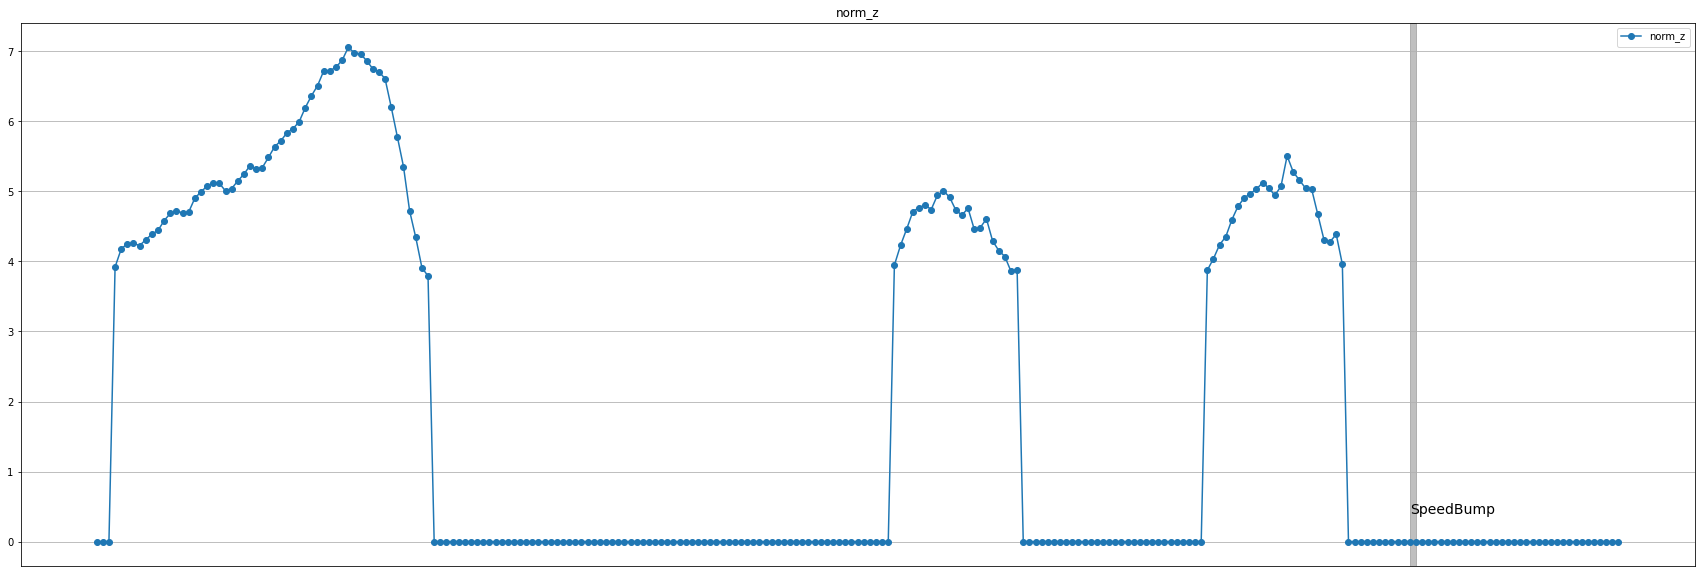

Shape: (249, 9)


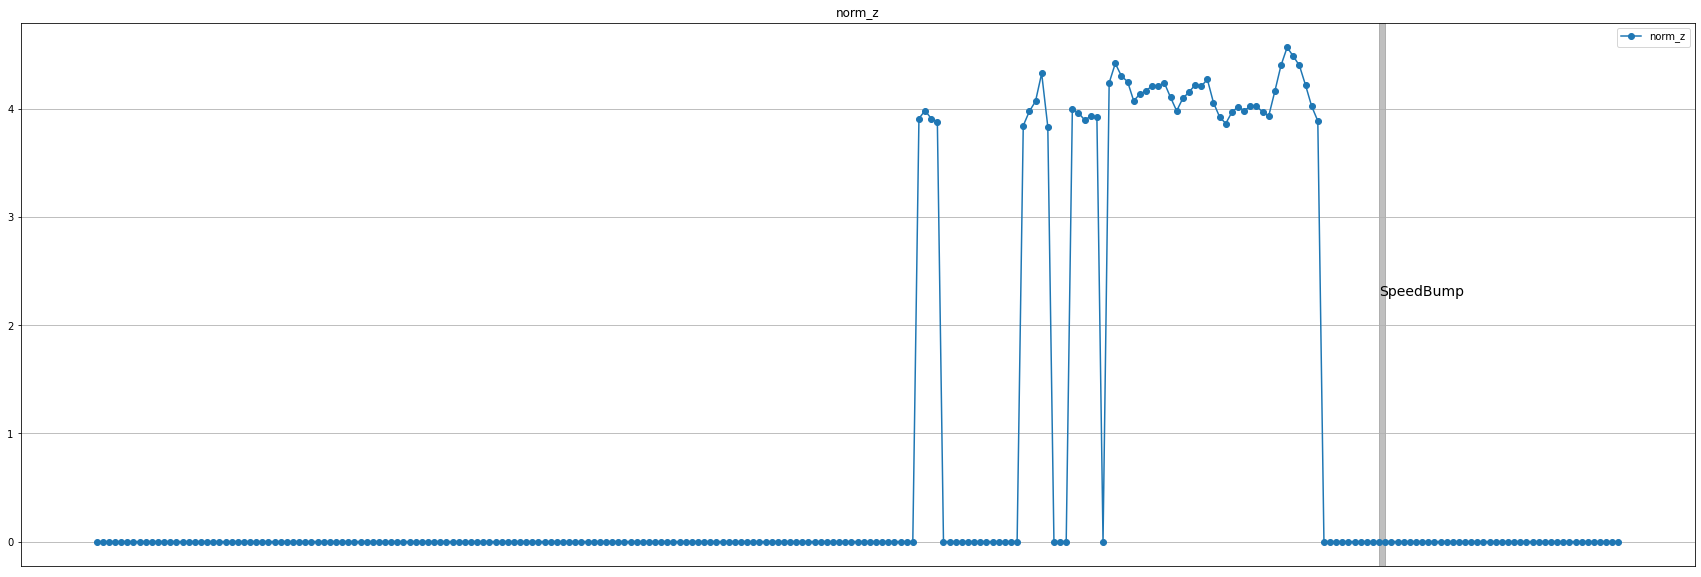

Shape: (249, 9)


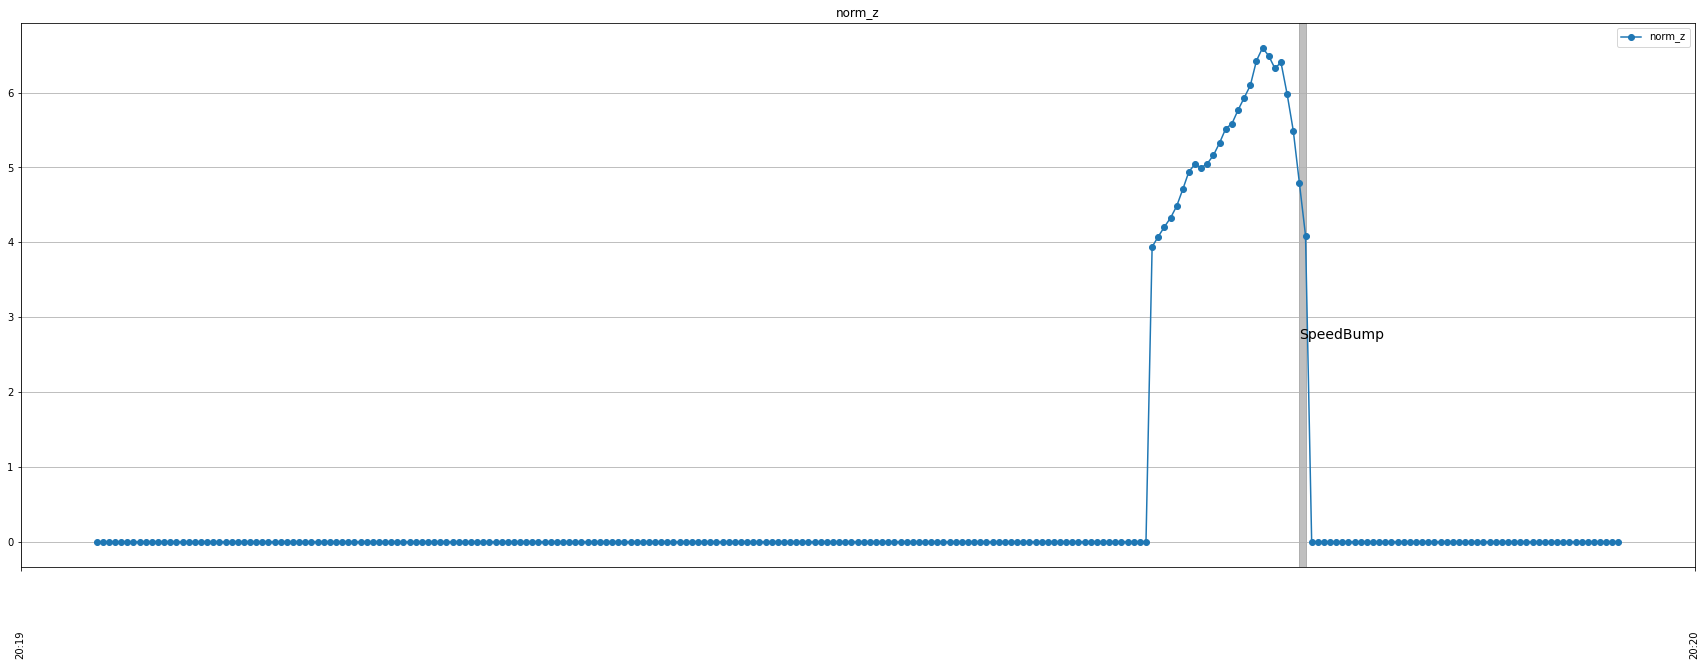

Shape: (249, 9)


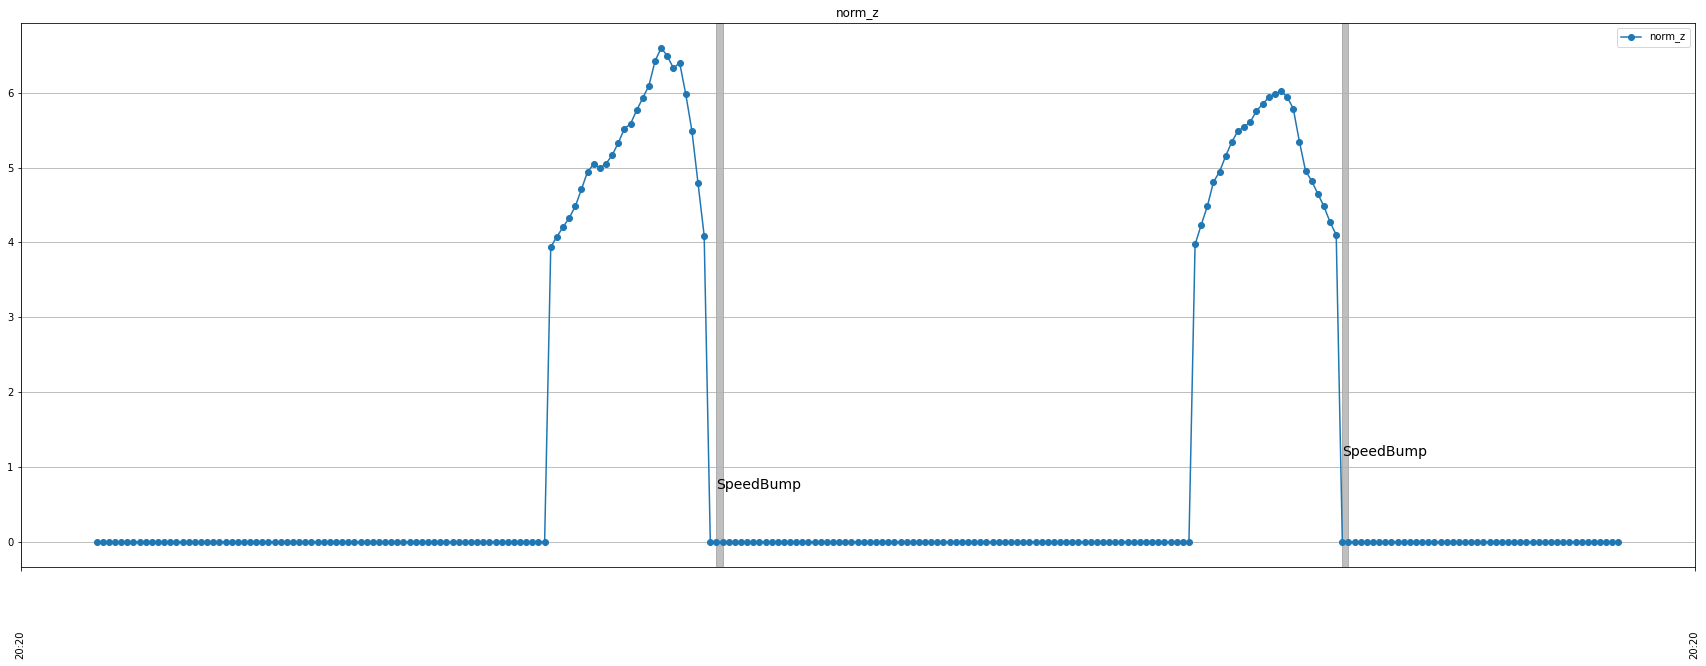

Shape: (249, 9)


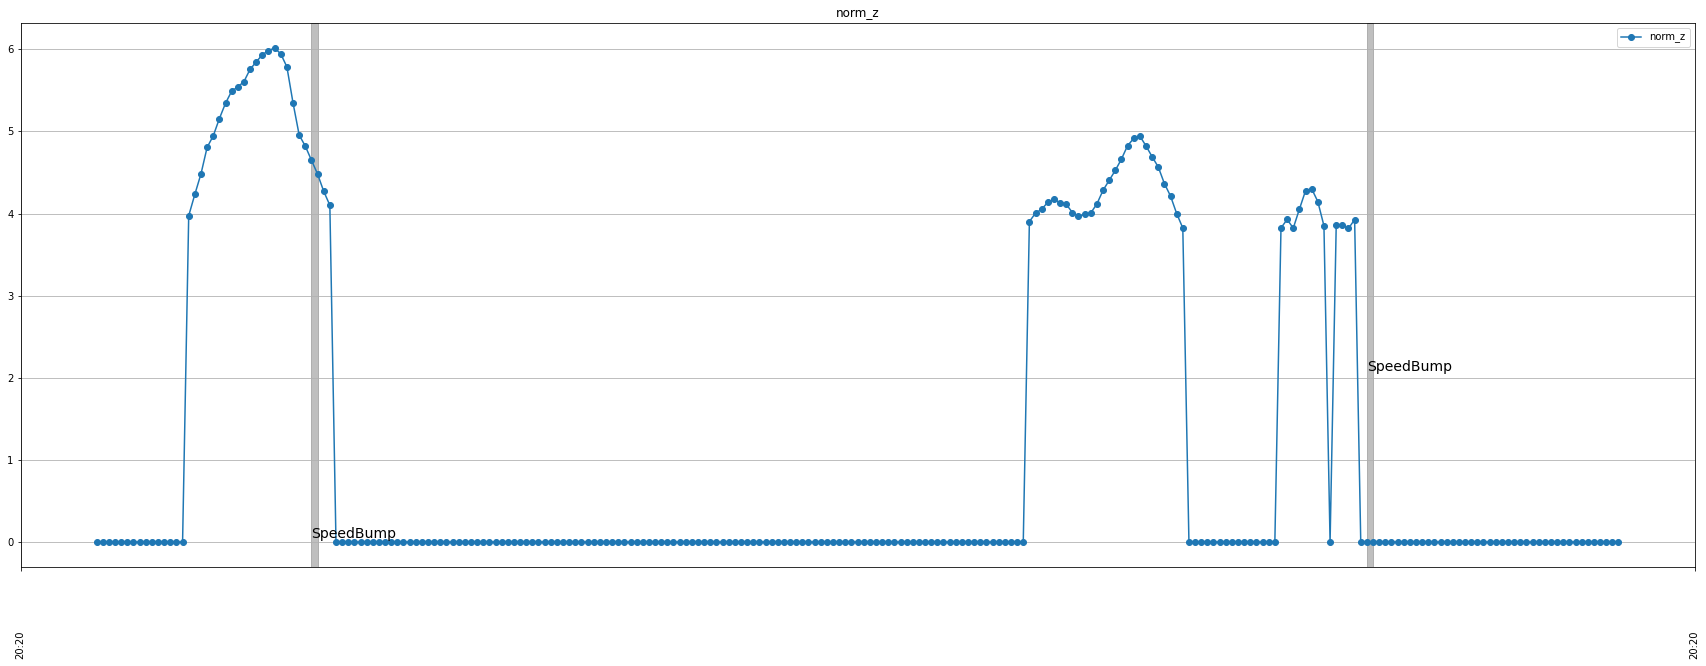

Shape: (249, 9)


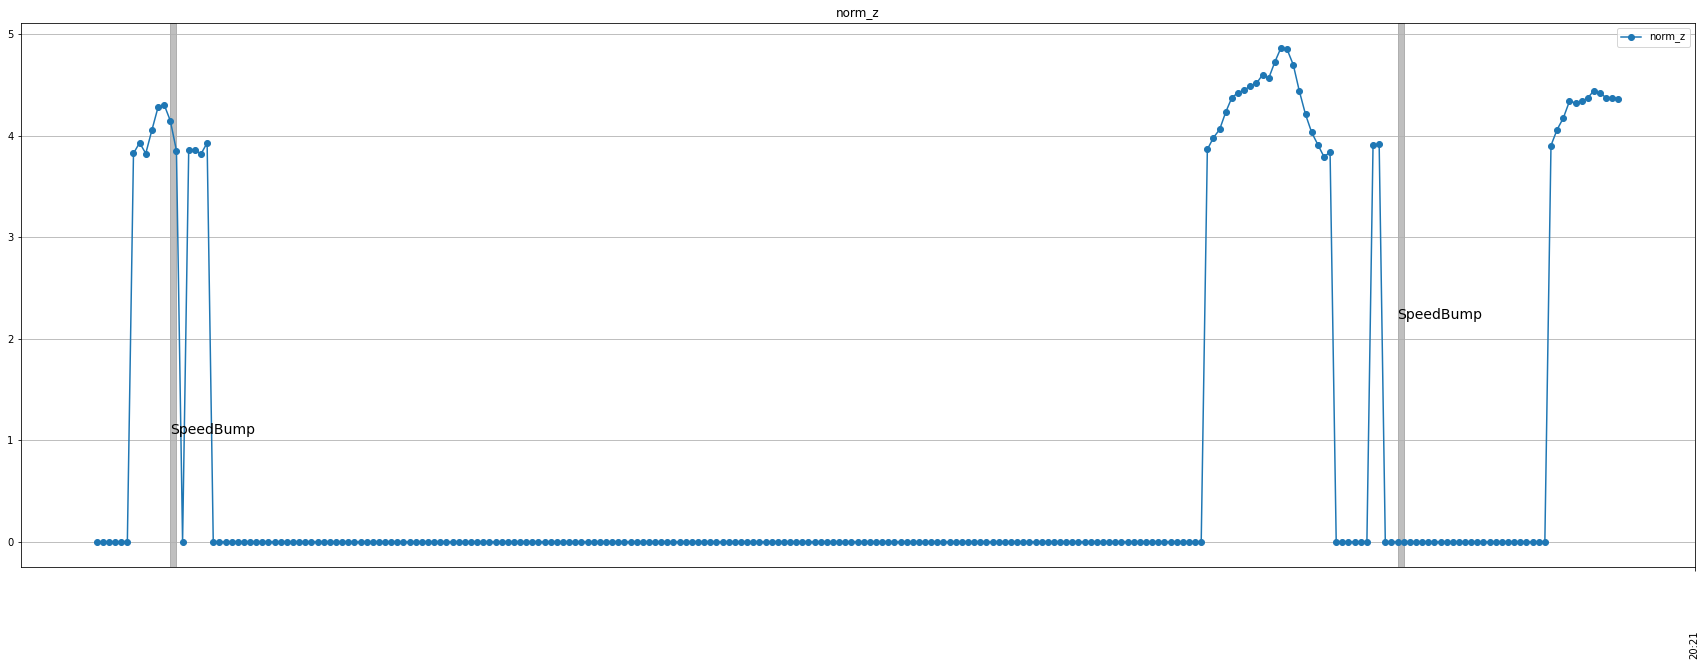

Shape: (249, 9)


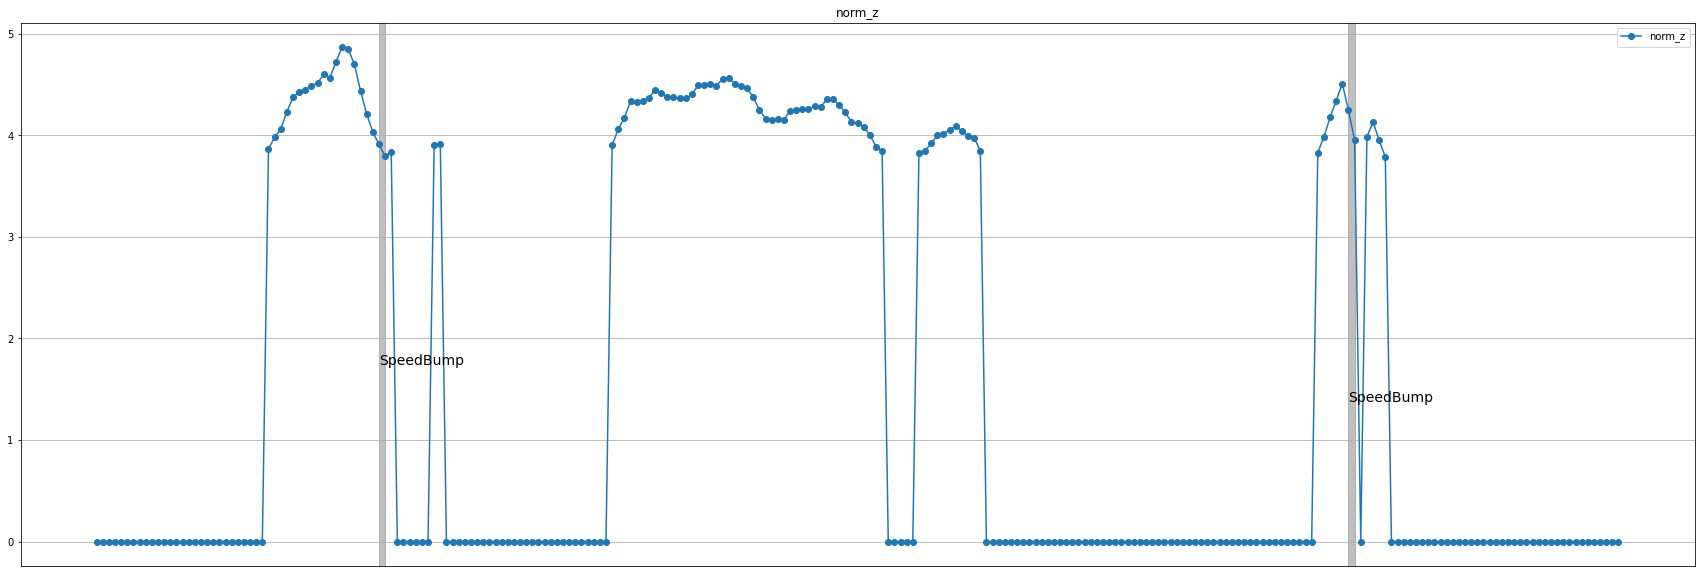

Shape: (249, 9)


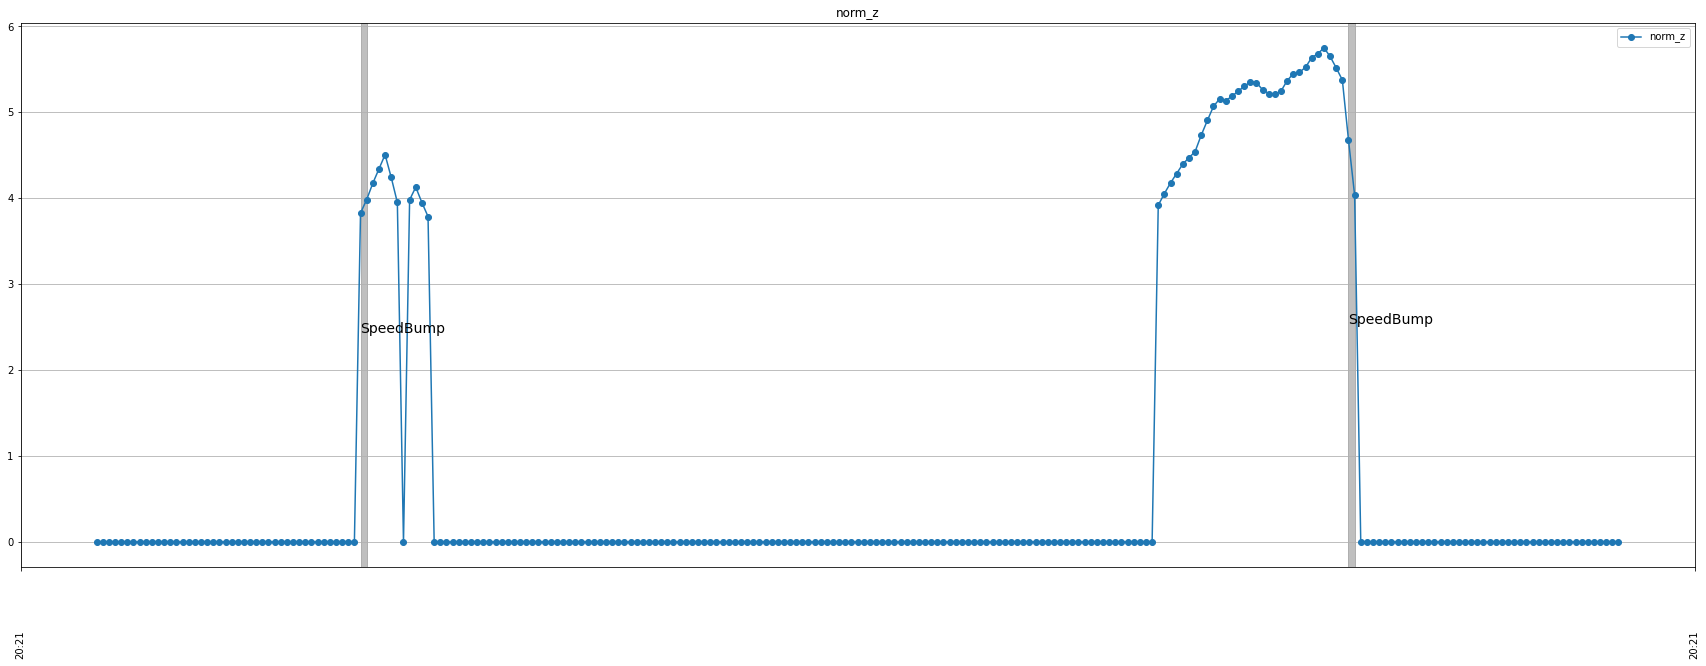

Shape: (249, 9)


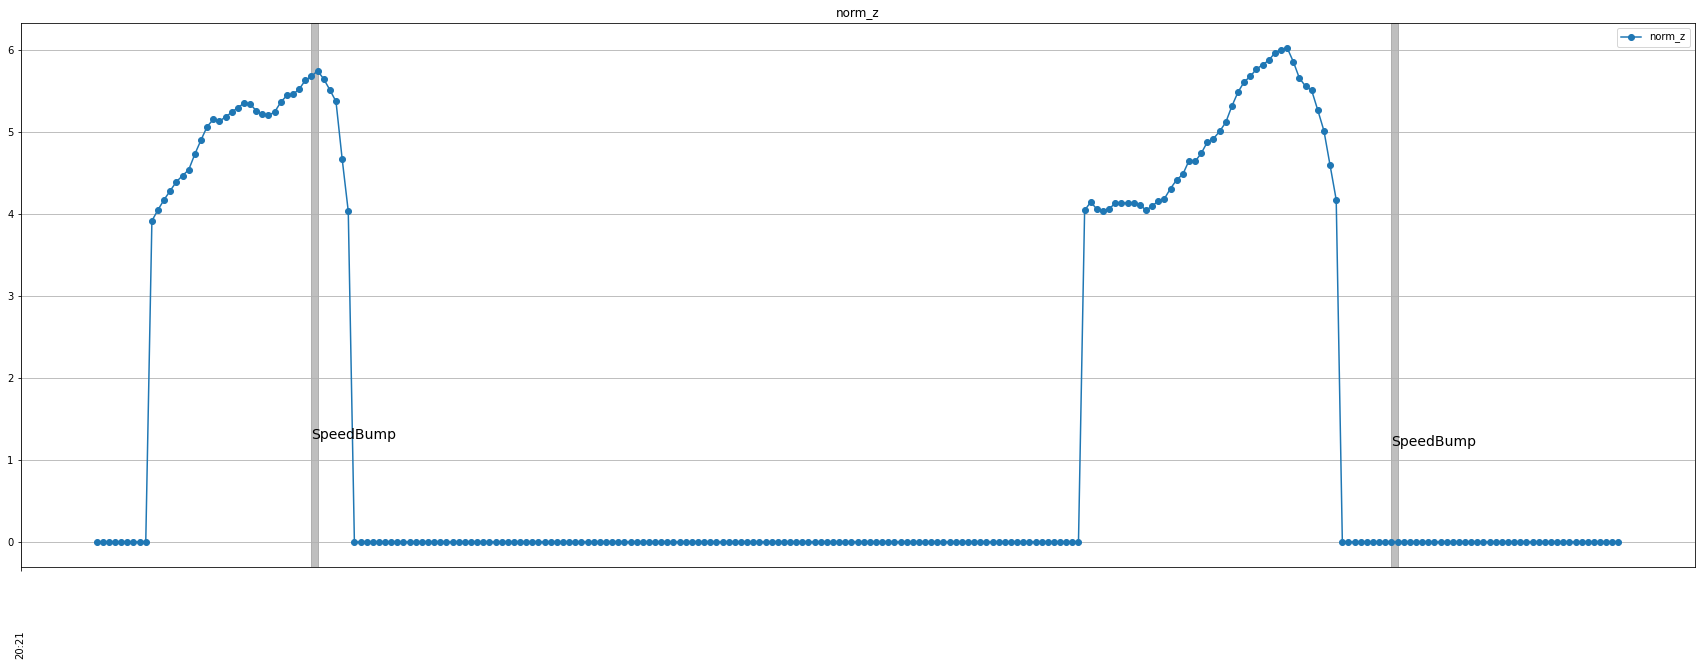

Shape: (249, 9)


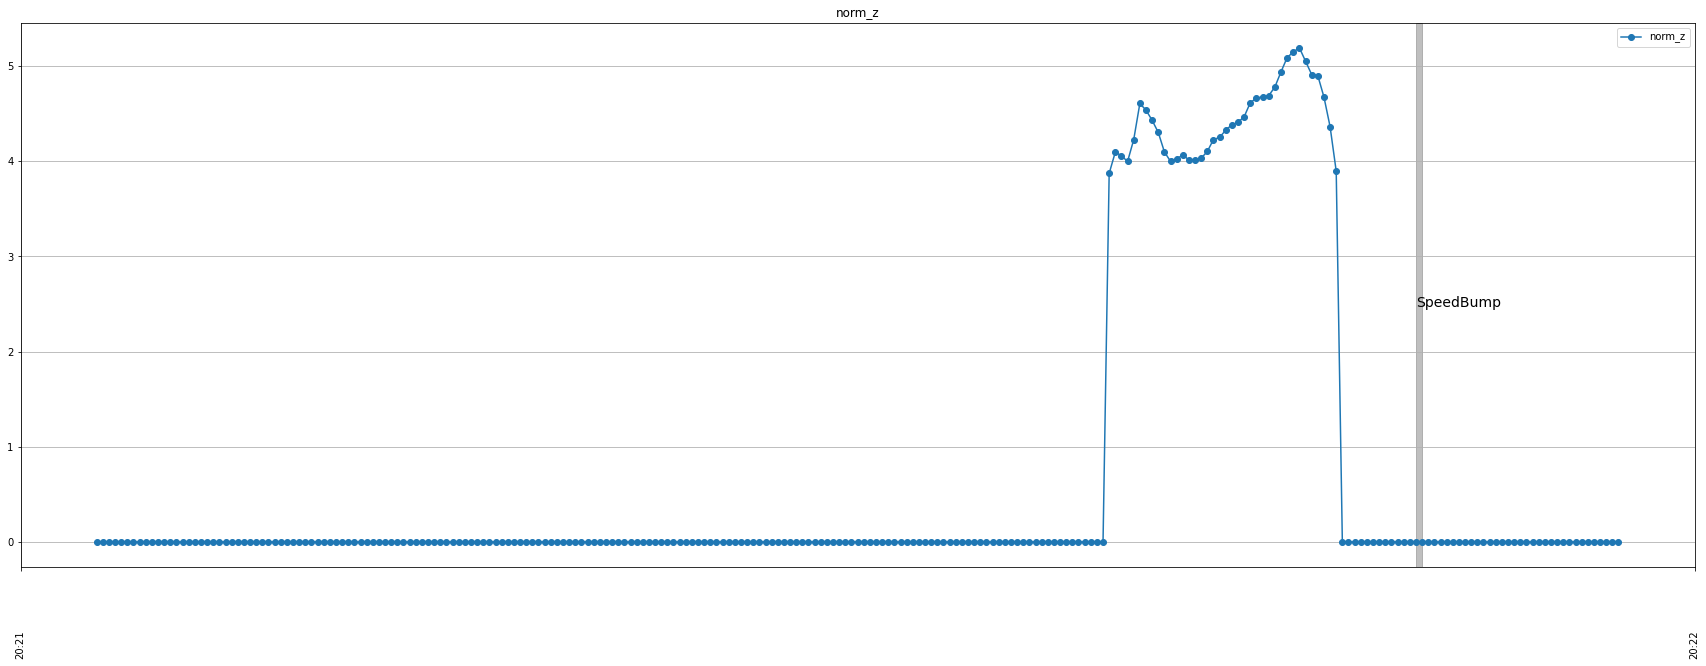

In [1096]:
count = 0

previous_base_date = list(mapping_timestamp_event.keys())[0] - pd.Timedelta(minutes=10)
for base_date in list(mapping_timestamp_event.keys()):
    elapsed_time = base_date - previous_base_date
    
    if elapsed_time.seconds < 5:
        continue

    start_date = (base_date - pd.Timedelta(seconds=20)).strftime('%d/%m/%Y %H:%M:%S.%f')
    end_date   = (base_date + pd.Timedelta(seconds=5)).strftime('%d/%m/%Y %H:%M:%S.%f')

    special_points = {}
    special_points[previous_base_date.strftime('%d/%m/%Y %H:%M:%S.%f')] = 'SpeedBump'
    #special_points[(mapping_timestamp_event[base_date]['new'] - pd.Timedelta(seconds=5)).strftime('%d/%m/%Y %H:%M:%S.%f')] = 'Braking'
    special_points[mapping_timestamp_event[base_date]['new'].strftime('%d/%m/%Y %H:%M:%S.%f')] = 'SpeedBump'
    #special_points[base_date.strftime('%d/%m/%Y %H:%M:%S.%f')] = 'Old'

    plot_manipulator.plot_timeseries(df,['norm_z'], start_date, end_date, legend=['norm_z'], special_dates=special_points)

    count +=1

    previous_base_date = base_date

    if count >= 20:
        break

## Salva o dataframe de saída

In [833]:
out_filename = get_out_filename(prefix='2_')
df_filtered.to_csv(out_filename, sep=output_config['file']['delimiter'], header=output_config['file']['with_header'])
print(f'O arquivo {out_filename} foi gerado!')

O arquivo ./out/2_export_lunar_20200517.csv foi gerado!
